In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load Result Files of all Models

In [2]:
results_dict = {}

folder_path = "../bike_forecasting_daily/results"

if os.path.exists(folder_path) and os.path.isdir(folder_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            try:
                df = pd.read_csv(file_path, parse_dates=["Datetime"], index_col="Datetime")
                df.index = pd.to_datetime(df.index, utc=True)
                df.index = df.index.tz_convert('Europe/Berlin')
                
                results_dict[file_name[:-4]] = df
            except Exception as e:
                print(f"Error {file_name}: {e}")
else:
    print("Empty")

for key, value in results_dict.items():
    print(f"{key}: {value.shape}")

Baseline Forecast: (364, 6)
LightGBM: (364, 6)
Mean Ensemble: (364, 6)
Median Ensemble: (364, 6)
Quantile Regression Forest: (364, 6)
Quantile Regression: (364, 6)
XGBoost: (364, 6)


#### Filter Horizons

In [3]:
# Target-Horizons
target_horizons = [
    {"dayofweek": 1, "horizon": "1 day"},  # Freitag 12:00 Stunde: 36 
    {"dayofweek": 2, "horizon": "2 day"},  # Freitag 16:00 Stunde: 40
    {"dayofweek": 3, "horizon": "3 day"},  # Freitag 20:00 Stunde: 44
    {"dayofweek": 4, "horizon": "4 day"},  # Samstag 12:00 Stunde: 60
    {"dayofweek": 5, "horizon": "5 day"},  # Samstag 16:00 Stunde: 64
    {"dayofweek": 6, "horizon": "6 day"},  # Samstag 20:00 Stunde: 68
]

# Filter for target horizons
for key, df in results_dict.items():
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    df["dayofweek"] = df.index.dayofweek
    filtered_df = pd.DataFrame()

    for mapping in target_horizons:
        day = mapping["dayofweek"]
        horizon = mapping["horizon"]

        subset = df[(df["dayofweek"] == day)].copy()
        subset["horizon"] = horizon

        filtered_df = pd.concat([filtered_df, subset])
        filtered_df = filtered_df.drop(columns=["dayofweek"])

    results_dict[key] = filtered_df
    
for key, value in results_dict.items():
    print(f"{key}: {value.shape}")

Baseline Forecast: (312, 7)
LightGBM: (312, 7)
Mean Ensemble: (312, 7)
Median Ensemble: (312, 7)
Quantile Regression Forest: (312, 7)
Quantile Regression: (312, 7)
XGBoost: (312, 7)


#### Quantile Loss Overview

In [4]:
# Quantile Loss
quantile_loss_dict = {}
for key, df in results_dict.items():
    quantiles = [col for col in df.columns if col.startswith("q")]
    target = df["target"].values

    loss_df = df.copy()

    for q_col in quantiles:
        q = float(q_col[1:])
        y_pred = df[q_col].values
        loss = np.where(y_pred > target, 
                         (1 - q) * (y_pred - target), 
                          q * (target - y_pred))
        loss_df[q_col] = loss

    quantile_loss_dict[key] = loss_df

In [5]:
summary_rows = []

for model_name, loss_df in quantile_loss_dict.items():
    quantile_cols = [col for col in loss_df.columns if col.startswith("q")]
    
    avg_losses = loss_df[quantile_cols].mean()

    total_loss = avg_losses.sum()
    
    row = avg_losses.to_dict()
    row['Total Average Loss'] = total_loss
    row['Model'] = model_name
    
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index('Model')
summary_df = summary_df[sorted([col for col in summary_df.columns if col.startswith("q")]) + ['Total Average Loss']]

summary_df = summary_df.sort_values(by='Total Average Loss', ascending=False)

summary_df = summary_df.round(2)

In [6]:
summary_df

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss
Model,,,,,,
Baseline Forecast,165.23,354.93,371.90,254.74,60.24,1207.04
XGBoost,50.10,206.09,245.45,188.60,46.00,736.24
Mean Ensemble,49.77,202.59,239.62,185.92,44.77,722.68
Median Ensemble,49.77,202.59,239.62,185.92,44.77,722.68
Quantile Regression,53.87,195.50,222.31,174.09,75.35,721.11
LightGBM,50.39,203.42,238.22,184.98,43.95,720.96
Quantile Regression Forest,36.02,149.51,184.95,152.44,34.43,557.35


#### Qauntil Coverage Overview

In [7]:
# Covergae by

coverage_dict = {}

for model_name, df in results_dict.items():
    quantiles = [col for col in df.columns if col.startswith("q")]
    target = df["target"].values
    coverage_df = pd.DataFrame(index=df.index)

    for q_col in quantiles:
        preds = df[q_col].values
        coverage_df[q_col] = (target <= preds).astype(int)

    coverage_dict[model_name] = coverage_df

In [8]:
coverage_rows = []

for model_name, coverage_df in coverage_dict.items():
    avg_coverage = coverage_df.mean()
    row = avg_coverage.to_dict()
    row["Modell"] = model_name
    coverage_rows.append(row)

coverage_summary = pd.DataFrame(coverage_rows)
coverage_summary = coverage_summary.set_index("Modell")
coverage_summary = coverage_summary[sorted(coverage_summary.columns)]


In [9]:
coverage_summary.round(2)

,q0.025,q0.25,q0.5,q0.75,q0.975
Modell,,,,,
Baseline Forecast,0.18,0.31,0.48,0.70,0.87
LightGBM,0.06,0.35,0.62,0.81,0.97
Mean Ensemble,0.05,0.35,0.62,0.81,0.97
Median Ensemble,0.05,0.35,0.62,0.81,0.97
Quantile Regression Forest,0.01,0.25,0.57,0.89,0.99
Quantile Regression,0.04,0.34,0.58,0.79,0.93
XGBoost,0.06,0.35,0.62,0.81,0.97


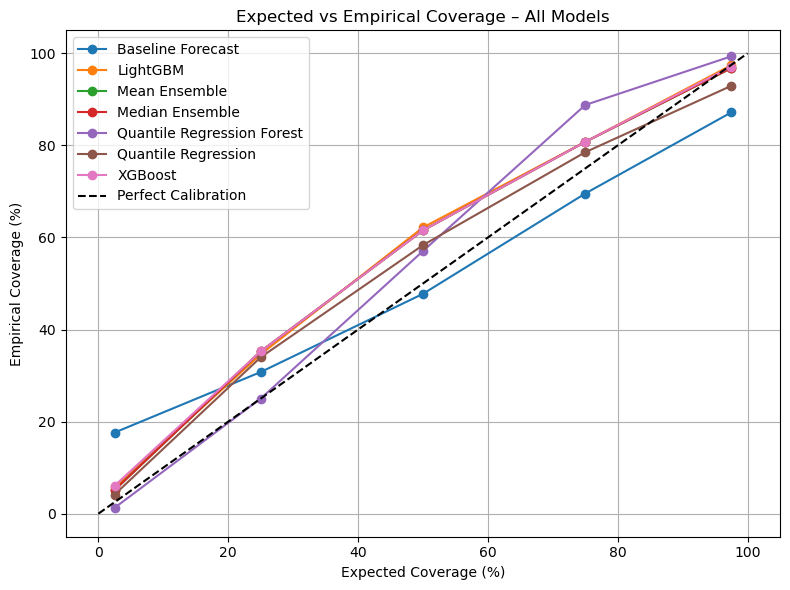

In [10]:
plt.figure(figsize=(8, 6))

expected_coverages = [float(col[1:]) * 100 for col in coverage_summary.columns]

for model_name, row in coverage_summary.iterrows():
    plt.plot(expected_coverages, row.values * 100, marker='o', label=model_name)

plt.plot([0, 100], [0, 100], linestyle='--', color='black', label="Perfect Calibration")

plt.xlabel("Expected Coverage (%)")
plt.ylabel("Empirical Coverage (%)")
plt.title("Expected vs Empirical Coverage – All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
expected_coverage = {col: float(col[1:]) for col in coverage_summary.columns}

calibration_deviation = pd.DataFrame(index=coverage_summary.index)

for col in coverage_summary.columns:
    calibration_deviation[col] = expected_coverage[col] - coverage_summary[col]

calibration_deviation = calibration_deviation.round(2)


In [12]:
calibration_deviation

,q0.025,q0.25,q0.5,q0.75,q0.975
Modell,,,,,
Baseline Forecast,-0.15,-0.06,0.02,0.05,0.10
LightGBM,-0.03,-0.10,-0.12,-0.06,0.00
Mean Ensemble,-0.03,-0.10,-0.12,-0.06,0.01
Median Ensemble,-0.03,-0.10,-0.12,-0.06,0.01
Quantile Regression Forest,0.01,0.00,-0.07,-0.14,-0.02
Quantile Regression,-0.02,-0.09,-0.08,-0.04,0.05
XGBoost,-0.04,-0.10,-0.12,-0.06,0.00


#### Interval Coverage

In [13]:
interval_coverage_rows = []

for model_name, df in results_dict.items():
    lower_95 = df["q0.025"]
    upper_95 = df["q0.975"]
    lower_50 = df["q0.25"]
    upper_50 = df["q0.75"]
    target = df["target"]

    coverage_95 = ((target >= lower_95) & (target <= upper_95)).mean()
    coverage_50 = ((target >= lower_50) & (target <= upper_50)).mean()

    interval_coverage_rows.append({
        "Modell": model_name,
        "CI_50 Coverage": coverage_50,
        "CI_95 Coverage": coverage_95
    })

interval_coverage_df = pd.DataFrame(interval_coverage_rows)
interval_coverage_df = interval_coverage_df.set_index("Modell").round(2)


#### Quantile Loss and Coverage

In [14]:
quantile_loss_ci_coverage = summary_df.copy()
quantile_loss_ci_coverage = quantile_loss_ci_coverage.join(interval_coverage_df)

In [15]:
quantile_loss_ci_coverage

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage
Model,,,,,,,,
Baseline Forecast,165.23,354.93,371.90,254.74,60.24,1207.04,0.39,0.70
XGBoost,50.10,206.09,245.45,188.60,46.00,736.24,0.46,0.91
Mean Ensemble,49.77,202.59,239.62,185.92,44.77,722.68,0.46,0.92
Median Ensemble,49.77,202.59,239.62,185.92,44.77,722.68,0.46,0.92
Quantile Regression,53.87,195.50,222.31,174.09,75.35,721.11,0.45,0.90
LightGBM,50.39,203.42,238.22,184.98,43.95,720.96,0.46,0.92
Quantile Regression Forest,36.02,149.51,184.95,152.44,34.43,557.35,0.64,0.98


##### Model Results Visualization

C:\Users\Tim Flaschel\AppData\Local\Temp\ipykernel_14736\996301231.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc["2024-11-01":]


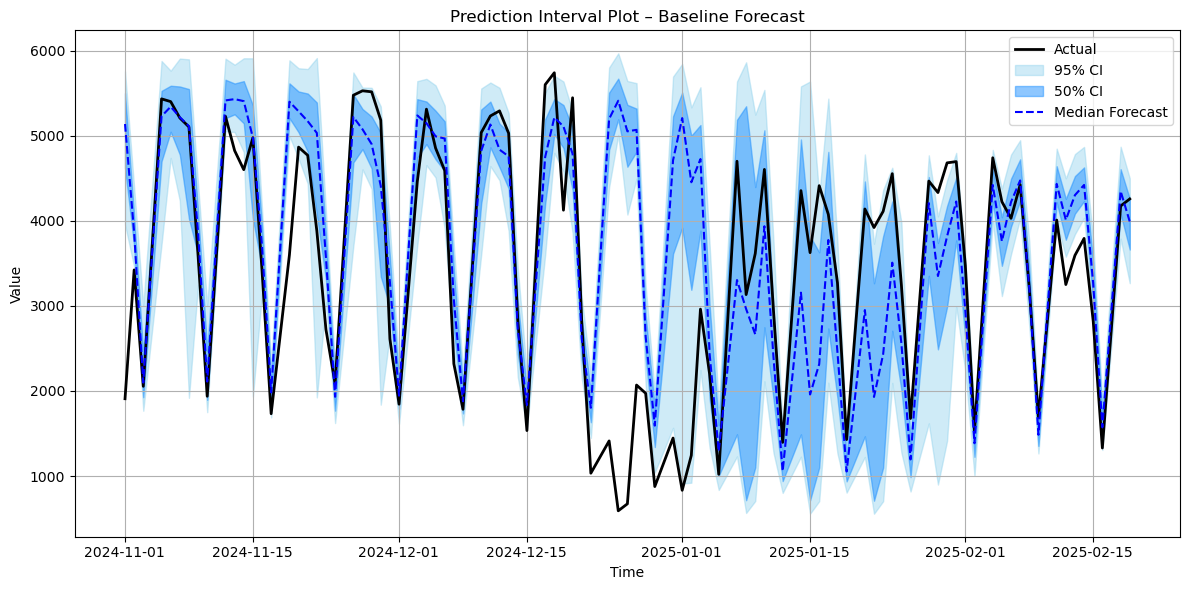

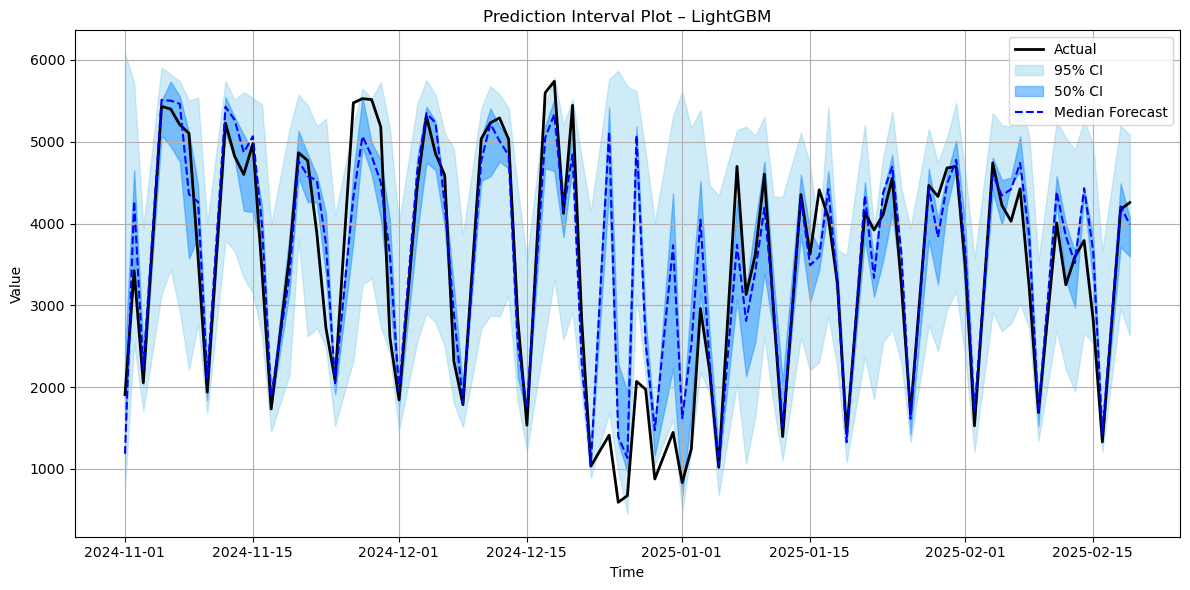

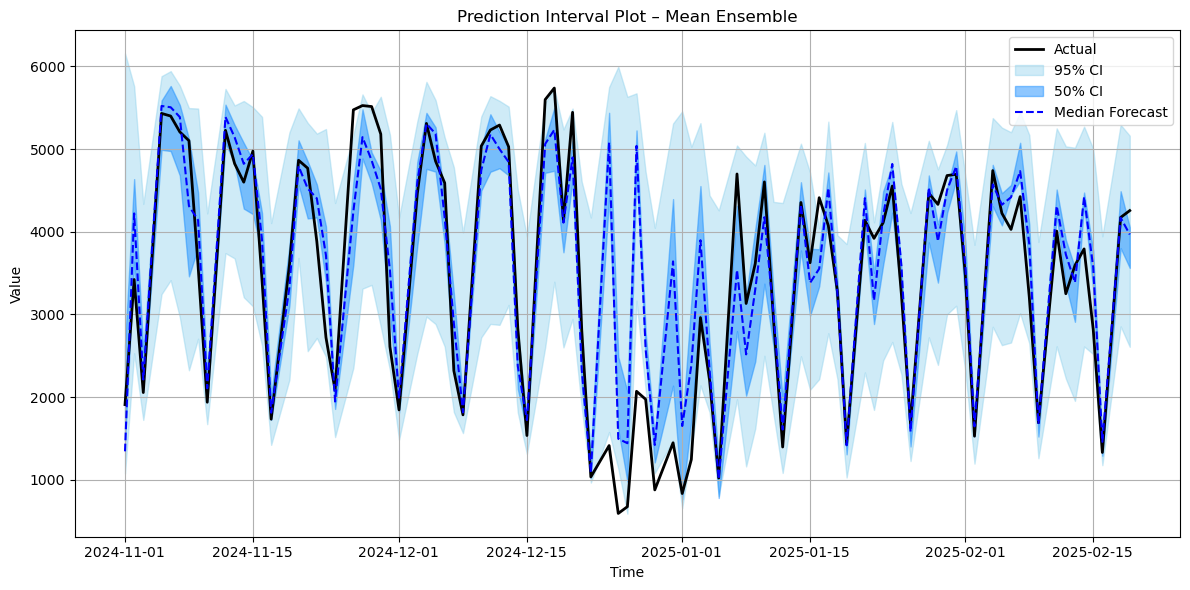

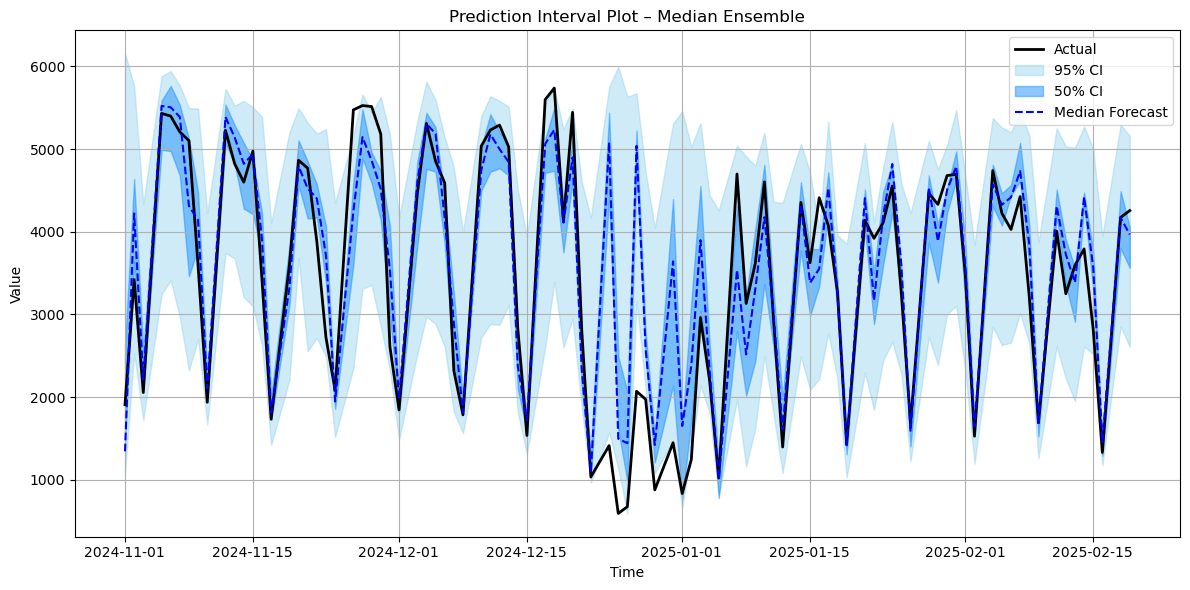

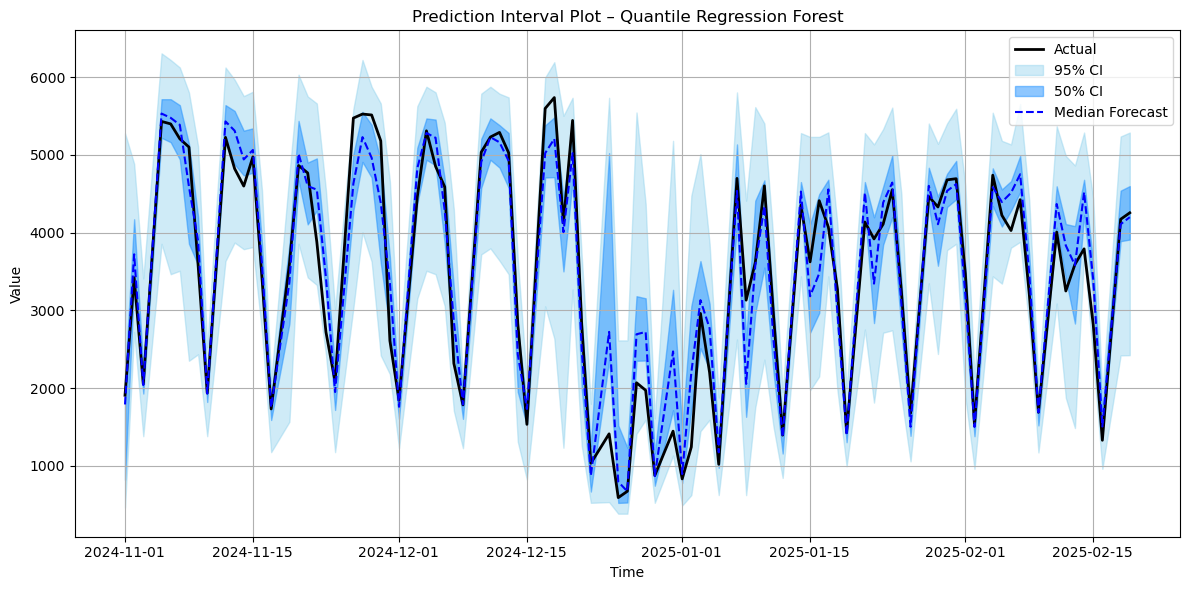

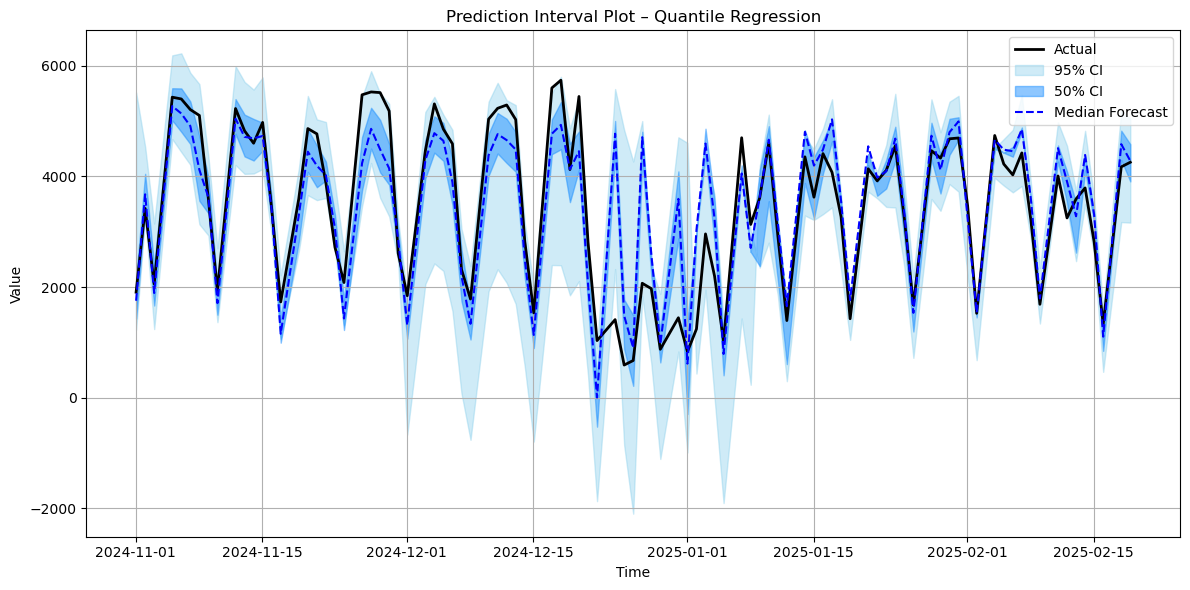

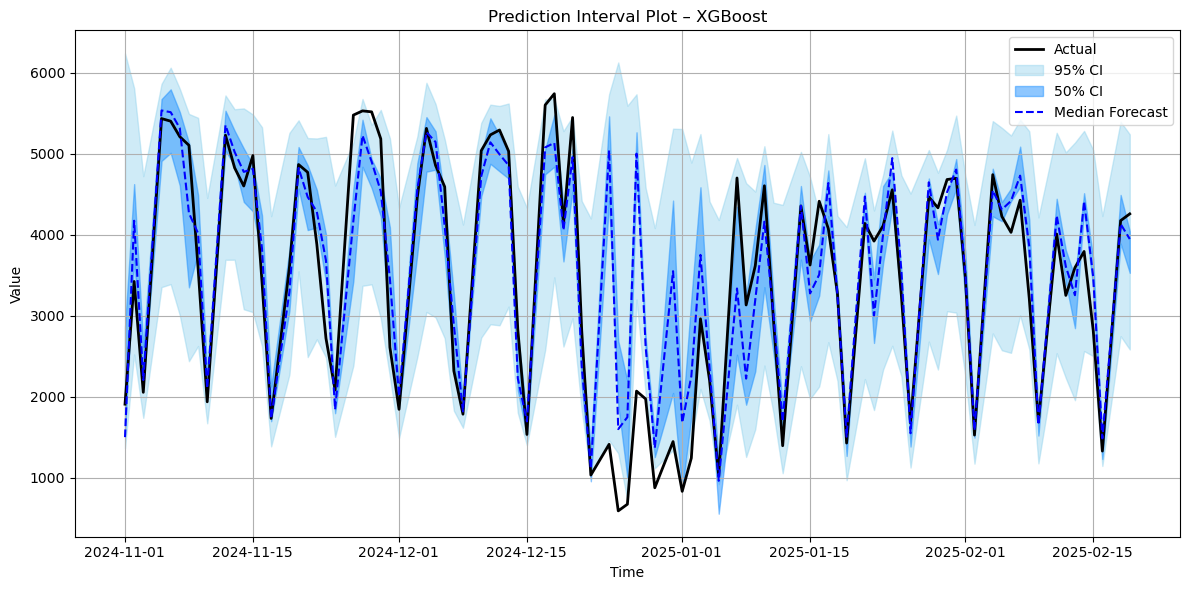

In [16]:
for model_name, df in results_dict.items():
    # Filter by date range
    
    df = df.loc["2024-11-01":]
    plt.figure(figsize=(12, 6))
    df = df.sort_index()
    x = df.index
    y_actual = df["target"]
    q025 = df["q0.025"]
    q975 = df["q0.975"]
    q25 = df["q0.25"]
    q75 = df["q0.75"]
    q50 = df["q0.5"]

    plt.plot(x, y_actual, color="black", label="Actual", linewidth=2)
    plt.fill_between(x, q025, q975, color="skyblue", alpha=0.4, label="95% CI")
    plt.fill_between(x, q25, q75, color="dodgerblue", alpha=0.5, label="50% CI")
    plt.plot(x, q50, color="blue", linestyle="--", label="Median Forecast")

    plt.title(f"Prediction Interval Plot – {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### PIT Plots

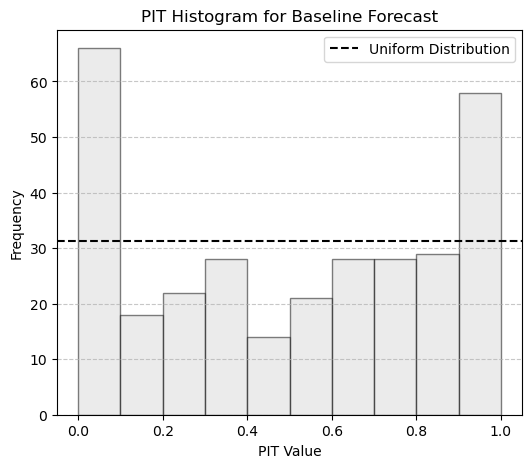

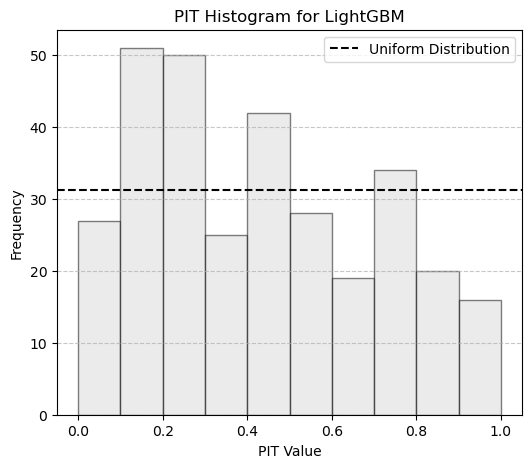

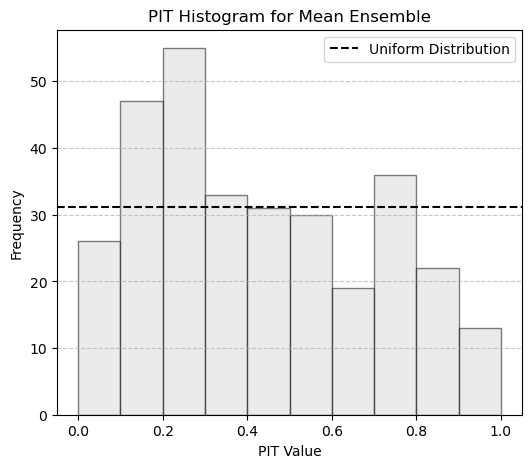

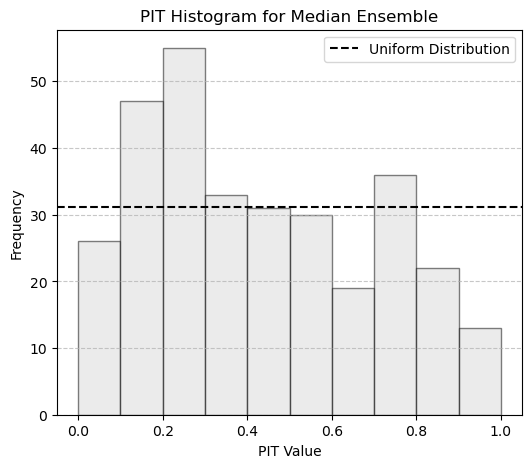

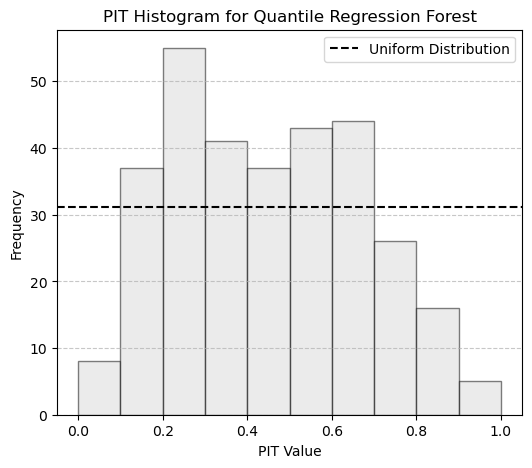

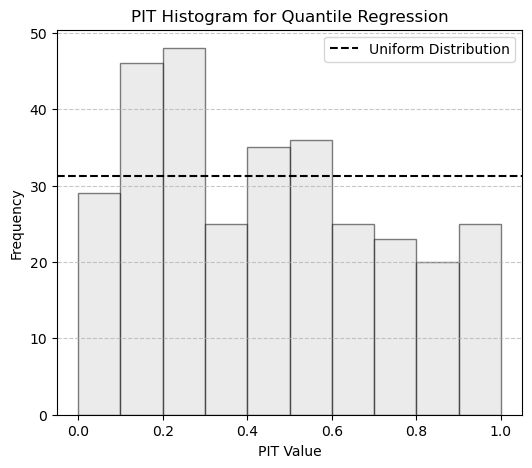

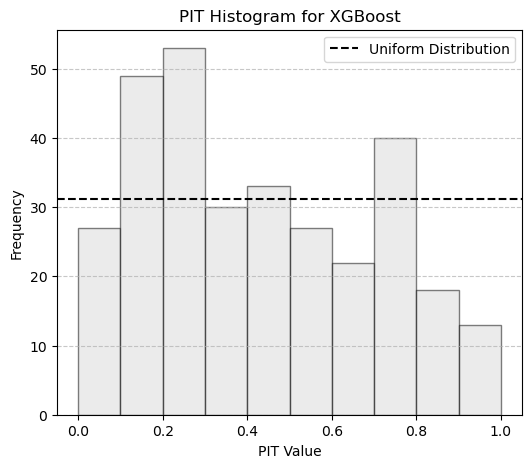

In [17]:
def calculate_pit(row):
    y_target = row['target']
    quantiles = [row['q0.025'], row['q0.25'], row['q0.5'], row['q0.75'], row['q0.975']]
    tau = [0.025, 0.25, 0.5, 0.75, 0.975]
    
    if y_target <= quantiles[0]:
        return 0.0
    
    elif y_target >= quantiles[-1]:
        return 1.0
    
    for i in range(len(quantiles) - 1):
        if quantiles[i] <= y_target <= quantiles[i + 1]:
            return tau[i] + (y_target - quantiles[i]) / (quantiles[i + 1] - quantiles[i]) * (tau[i + 1] - tau[i])
    return np.nan 

def plot_pit_histogram_for_dict(results_dict):

    for model_name, df in results_dict.items():

        df['PIT'] = df.apply(calculate_pit, axis=1)
        
        plt.figure(figsize=(6, 5))
        plt.hist(df['PIT'].dropna(), bins=10, range=(0, 1), edgecolor='black', alpha=0.5, color='#D9D9D9')
        plt.title(f'PIT Histogram for {model_name}')
        plt.xlabel('PIT Value')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.axhline(y=len(df['PIT']) / 10, color='black', linestyle='--', label='Uniform Distribution')
        plt.legend()
        plt.show()

plot_pit_histogram_for_dict(results_dict)

#### Horizon Results

In [18]:
quantile_loss_dict["Median Ensemble"]

,target,q0.025,q0.25,q0.5,q0.75,q0.975,horizon
Datetime,,,,,,,
2024-02-27 01:00:00+01:00,5020.0,43.052912,112.484209,79.782913,58.391588,12.486922,1 day
2024-03-05 01:00:00+01:00,4681.0,38.062898,16.233049,185.021227,141.331696,20.603332,1 day
2024-03-12 01:00:00+01:00,4500.0,41.393649,139.535409,60.158815,25.356136,15.939088,1 day
2024-03-19 01:00:00+01:00,5595.0,48.589312,125.406511,4.686713,65.530498,15.455131,1 day
2024-03-26 01:00:00+01:00,5187.0,35.727381,96.119127,363.918950,224.519171,30.999121,1 day
...,...,...,...,...,...,...,...
2025-01-19 01:00:00+01:00,1428.0,10.049784,30.465834,6.053027,34.063685,60.576104,6 day
2025-01-26 01:00:00+01:00,1676.0,11.272596,68.587872,47.801404,2.067664,63.764194,6 day
2025-02-02 01:00:00+01:00,1526.0,8.313836,0.478535,59.441887,38.990027,57.880718,6 day


In [19]:
horizon_results = {}

for model_name, df in quantile_loss_dict.items():
    quantile_cols = [col for col in df.columns if col.startswith("q")]
    
    grouped = df.groupby("horizon")[quantile_cols].mean()
    grouped = grouped.sort_index()

    # Add total average loss (sum across quantiles per horizon)
    grouped["Total Average Loss"] = grouped.sum(axis=1)

    horizon_results[model_name] = grouped



In [20]:
horizon_results["Median Ensemble"]

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss
horizon,,,,,,
1 day,79.123317,257.143288,269.533772,192.715302,38.942977,837.458655
2 day,51.525457,182.625705,212.394698,159.853355,34.050418,640.449634
3 day,47.552011,195.480933,236.746254,203.715871,45.855363,729.350432
4 day,63.863570,244.536985,266.246794,200.482787,37.695414,812.825550
5 day,33.905957,238.548010,323.968482,231.798041,50.672351,878.892842
6 day,22.651719,97.229563,128.855668,126.947611,61.391626,437.076187


#### Horizon CI Coverage

In [21]:
results_dict["Median Ensemble"]

,target,q0.025,q0.25,q0.5,q0.75,q0.975,horizon,PIT
Datetime,,,,,,,,
2024-02-27 01:00:00+01:00,5020.0,3297.883536,4570.063164,5179.565825,5253.566352,5519.476869,1 day,0.434551
2024-03-05 01:00:00+01:00,4681.0,3158.484085,4616.067804,5051.042453,5246.326783,5505.133277,1 day,0.287320
2024-03-12 01:00:00+01:00,4500.0,2844.254053,3941.858362,4379.682369,4601.424545,5137.563504,1 day,0.635650
2024-03-19 01:00:00+01:00,5595.0,3651.427510,5093.373958,5604.373425,5857.121994,6213.205233,1 day,0.495414
2024-03-26 01:00:00+01:00,5187.0,3757.904755,5315.158836,5914.837901,6085.076682,6426.964853,1 day,0.231483
...,...,...,...,...,...,...,...,...
2025-01-19 01:00:00+01:00,1428.0,1026.008653,1306.136662,1415.893945,1564.254740,3851.044161,6 day,0.520400
2025-01-26 01:00:00+01:00,1676.0,1225.096174,1401.648510,1580.397192,1684.270655,4226.567755,6 day,0.730094
2025-02-02 01:00:00+01:00,1526.0,1193.446541,1524.085862,1644.883773,1681.960108,3841.228723,6 day,0.253961


In [22]:
horizon_coverage = {}

for model_name, df in results_dict.items():
    ci_95 = (df["target"] >= df["q0.025"]) & (df["target"] <= df["q0.975"])
    ci_50 = (df["target"] >= df["q0.25"]) & (df["target"] <= df["q0.75"])

    df["CI_95_Width"] = df["q0.975"] - df["q0.025"]
    df["CI_50_Width"] = df["q0.75"] - df["q0.25"]

    df_temp = df.copy()
    df_temp["CI_95_Coverage"] = ci_95.astype(int)
    df_temp["CI_50_Coverage"] = ci_50.astype(int)

    grouped = df_temp.groupby("horizon")[
        ["CI_50_Coverage", "CI_95_Coverage", "CI_50_Width", "CI_95_Width"]
    ].mean()

    grouped = grouped.rename(columns={
        "CI_50_Coverage": "CI_50 Coverage",
        "CI_95_Coverage": "CI_95 Coverage",
        "CI_50_Width": "CI_50 Width",
        "CI_95_Width": "CI_95 Width"
    })

    horizon_coverage[model_name] = grouped.round(3)



In [23]:
horizon_summary = {}

desired_columns_order = [
    'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975', 'Total Average Loss',
    'CI_50 Coverage', 'CI_95 Coverage', 'CI_50 Width', 'CI_95 Width'
]


for model_name in horizon_results:
    df_loss = horizon_results[model_name]
    df_cov = horizon_coverage.get(model_name)

    if df_cov is not None:
        combined = df_loss.join(df_cov)
        
        df_gerundet = combined.drop(columns=['CI_50 Coverage','CI_95 Coverage']).round(0).astype(int)
        
        df_gerundet['CI_50 Coverage'] = combined['CI_50 Coverage'].round(2)
        df_gerundet['CI_95 Coverage'] = combined['CI_95 Coverage'].round(2)
        
        df_gerundet = df_gerundet[desired_columns_order]

        horizon_summary[model_name] = df_gerundet

        


In [24]:
horizon_summary["Quantile Regression"]

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
1 day,79,259,283,215,110,946,0.52,0.81,688,2119
2 day,34,182,216,174,83,688,0.48,0.94,787,2229
3 day,62,191,204,162,49,669,0.54,0.94,831,2197
4 day,55,232,249,183,51,770,0.38,0.96,691,2376
5 day,47,160,190,151,73,621,0.46,0.90,583,1602
6 day,45,148,192,159,87,631,0.31,0.85,534,1760


In [25]:
horizon_summary["XGBoost"]

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
1 day,75,262,277,196,41,851,0.58,0.90,839,2679
2 day,55,189,220,158,37,658,0.50,0.92,825,2817
3 day,50,200,240,211,43,744,0.48,0.86,869,2852
4 day,63,240,274,208,36,821,0.42,0.94,867,2760
5 day,32,235,329,232,52,880,0.35,0.94,855,2878
6 day,25,110,134,128,68,464,0.40,0.88,326,3090


In [26]:
horizon_summary["LightGBM"]

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
1 day,85,257,266,191,39,838,0.62,0.86,830,2556
2 day,48,178,215,164,32,637,0.54,0.94,827,2725
3 day,46,197,236,202,49,729,0.54,0.92,837,2809
4 day,65,252,265,195,39,816,0.48,0.94,850,2688
5 day,36,245,319,231,50,881,0.27,0.94,812,2809
6 day,23,92,128,127,55,424,0.35,0.88,313,2559


In [27]:
horizon_summary["Quantile Regression Forest"]

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
1 day,57,191,210,177,34,671,0.62,0.94,810,2662
2 day,39,144,192,163,31,570,0.60,1.00,826,2803
3 day,36,154,186,145,37,558,0.71,1.00,856,2946
4 day,39,192,198,155,37,622,0.56,0.98,840,2867
5 day,27,144,227,176,42,616,0.58,1.00,885,2752
6 day,17,71,97,98,25,308,0.77,0.96,476,1645
